In [1]:
# Cell 0 — Setup
#  - Imports
#  - A helper to auto-install missing packages into THIS kernel

import sys, subprocess, importlib, os, math, random, json
from pathlib import Path
from typing import Tuple, List, Dict

import numpy as np
from PIL import Image

def ensure(pkg_pypi: str, import_name: str):
    """
    Try to import 'import_name'; if it fails, pip-install 'pkg_pypi' into this kernel.
    Return the imported module.
    """
    try:
        return importlib.import_module(import_name)
    except ModuleNotFoundError:
        print(f"Installing {pkg_pypi} into this kernel...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", pkg_pypi])
        return importlib.import_module(import_name)

# Colour science, YAML, Pandas, Matplotlib, TIFF writer
C = ensure("colour-science", "colour")
yaml = ensure("pyyaml", "yaml")
pd   = ensure("pandas", "pandas")
plt  = ensure("matplotlib", "matplotlib"); import matplotlib.pyplot as plt
tiff = ensure("tifffile", "tifffile")

# Colour utilities
from colour.notation.munsell import munsell_colour_to_xyY
from colour.difference import delta_E_CIE2000

print("colour-science:", C.__version__)

colour-science: 0.4.6


In [2]:
# Cell 1 — Load configuration and define switches

CFG_PATH = "/Users/kate/Documents/retina-model/configs/baseline.yaml"

with open(CFG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

# --- Paths ---
IN_ROOT   = Path(cfg["paths"]["input_root"])
OUT_ROOT  = Path(cfg["paths"]["output_root"])
OUT_ROOT.mkdir(parents=True, exist_ok=True)

# --- Image size (H, W) ---
IMG_H, IMG_W = cfg.get("image", {}).get("size", [64, 64])

# --- Sampling ---
SEED   = int(cfg["sampling"]["seed"])
TRIALS = dict(cfg["sampling"]["trials"])  # {'train':..., 'val':..., 'test':...}

# --- Colour knobs (new design) ---
FIXED_BG_LAB = np.array(cfg["colour"]["background_lab"], float)   # dataset-wide gray (Lab, D65)
L0           = float(cfg["colour"]["neutral_white_L0"])           # L* for "tinted white"
TINTS_MODE   = cfg["colour"]["tints"]                             # 'chromatic_16' (we build explicitly)
APPMODE      = cfg["colour"].get("appearance_match_mode", "direct")
DE_MIN_PRE   = float(cfg["colour"].get("deltaE_min_obj_vs_bg_pre", 0))

# --- Exposure policy (must be 'none' for this design) ---
EXPOSURE_MODE = cfg["colour"].get("exposure", {}).get("mode", "none")
assert EXPOSURE_MODE == "none", "This notebook assumes exposure.mode == 'none' (no scaling)."

# --- Gamut / resampling knobs ---
GAMUT             = cfg["gamut"]
MAX_ATTEMPTS      = int(GAMUT.get("max_attempts_per_trial", 100))
TINT_RS           = GAMUT.get("tint_resample", {})
RS_START_RANDOM   = bool(TINT_RS.get("start_random", True))
RS_RADII_DESC     = list(TINT_RS.get("radii_desc", [20, 15, 10, 5]))
RS_OBJ_IF_TINT    = bool(GAMUT.get("resample_object_if_tint_fails", True))
SKIP_IF_FAIL      = bool(GAMUT.get("skip_trial_if_fail", True))

# --- Reporting toggles ---
REPORT               = cfg.get("report", {})
SAVE_MANIFEST_CSV    = bool(REPORT.get("save_manifest_csv", True))
MANIFEST_SUBDIR      = REPORT.get("manifest_subdir", "manifests")
SAVE_PER_TRIAL_JSON  = bool(REPORT.get("save_per_trial_json", True))
INCLUDE_LAB          = bool(REPORT.get("include_lab", True))
INCLUDE_XYZ          = bool(REPORT.get("include_xyz", True))   # affects what we pack into NPZ (metadata/log), not PNG
INCLUDE_RGB          = bool(REPORT.get("include_rgb", True))   # affects CSV fields used by the viewer
RGB_AS_FLOAT         = bool(REPORT.get("rgb_as_float", False)) # (kept for future; we log 8-bit by default)

# NEW: control scientific outputs
SAVE_TIFF_XYZ        = bool(REPORT.get("save_tiff_xyz", True)) # float32 XYZ TIFF per image
SAVE_NPZ             = bool(REPORT.get("save_npz", True))      # NPZ with Lab/XYZ arrays + metadata

# --- Geometry ---
S_MIN, S_MAX     = map(int,   cfg["geometry"]["resize_max_dim"])
ROT_MIN, ROT_MAX = map(float, cfg["geometry"]["rotation_deg"])
T_MIN, T_MAX     = map(int,   cfg["geometry"]["translation_px"])
BORDER           = int(cfg["geometry"]["border_px"])

# --- Reproducibility ---
random.seed(SEED); np.random.seed(SEED)

print("Loaded config from:", CFG_PATH)
print({
    "in_root": str(IN_ROOT),
    "out_root": str(OUT_ROOT),
    "img_size": (IMG_H, IMG_W),
    "exposure_mode": EXPOSURE_MODE,
    "tint_order": ("full_random" if RS_START_RANDOM else f"ordered {RS_RADII_DESC}"),
    "report": {
        "lab": INCLUDE_LAB, "xyz": INCLUDE_XYZ, "rgb": INCLUDE_RGB,
        "tiff_xyz": SAVE_TIFF_XYZ, "npz": SAVE_NPZ
    }
})

Loaded config from: /Users/kate/Documents/retina-model/configs/baseline.yaml
{'in_root': '/Users/kate/Documents/retina-model/Image-set-1/original-bw-images/apples', 'out_root': '/Users/kate/Documents/retina-model/image-set', 'img_size': (64, 64), 'exposure_mode': 'none', 'tint_order': 'full_random', 'report': {'lab': True, 'xyz': True, 'rgb': True, 'tiff_xyz': True, 'npz': True}}


In [3]:
# Cell 2 — Build/validate the Munsell pool we'll sample object colours from.
# (We start from the canonical 1600 chromatic grid and keep only codes the
#  'colour-science' library can convert. Typically ~1587 remain.)

HUE_FAMILIES = ['R','YR','Y','GY','G','BG','B','PB','P','RP']
HUE_STEPS    = [2.5, 5, 7.5, 10]
VALUES       = list(range(2, 10))     # 2..9
CHROMAS      = [2, 4, 6, 8, 10]       # chromatic (no /0 here)

def canonical_chromatics() -> List[str]:
    return [f"{hs}{fam} {V}/{Cc}"
            for fam in HUE_FAMILIES
            for hs in HUE_STEPS
            for V in VALUES
            for Cc in CHROMAS]

def is_valid_munsell(code: str) -> bool:
    try:
        xyY = munsell_colour_to_xyY(code)
        arr = np.asarray(xyY, float)
        return arr.shape == (3,) and np.all(np.isfinite(arr))
    except Exception:
        return False

codes_1600 = canonical_chromatics()
chips_full  = [c for c in codes_1600 if is_valid_munsell(c)]
print(f"Validated chromatic chips (full): {len(chips_full)}  (nominal 1600; typical ~1587)")

Validated chromatic chips (full): 1587  (nominal 1600; typical ~1587)


In [4]:
# Cell 3 — Colour math utilities and the 16 tints

# sRGB color space with D65 white (used throughout)
RGB_CS = C.RGB_COLOURSPACES["sRGB"]
ill_xy = np.array(RGB_CS.whitepoint, float)  # xy whitepoint for sRGB (D65)

# -- Basic conversions --
def XYZ_to_Lab(XYZ: np.ndarray) -> np.ndarray:
    return C.XYZ_to_Lab(np.asarray(XYZ, float), RGB_CS.whitepoint)

def Lab_to_XYZ(Lab: np.ndarray) -> np.ndarray:
    return C.Lab_to_XYZ(np.asarray(Lab, float), RGB_CS.whitepoint)

def XYZ_to_rgb_linear(XYZ: np.ndarray) -> np.ndarray:
    # Note: Colour 0.4.6 signature → pass colourspace + whitepoint + CAT; no encoding
    return C.XYZ_to_RGB(np.asarray(XYZ, float), RGB_CS, ill_xy, "CAT02", apply_cctf_encoding=False)

def rgb_linear_to_XYZ(RGB_lin: np.ndarray) -> np.ndarray:
    return C.RGB_to_XYZ(np.asarray(RGB_lin, float), RGB_CS, ill_xy, "CAT02", apply_cctf_decoding=False)

def encode_sRGB(RGB_lin: np.ndarray) -> np.ndarray:
    # linear → display sRGB (gamma-encoded), still float [0..1]
    return RGB_CS.cctf_encoding(np.asarray(RGB_lin, float))

def deltaE00(Lab1, Lab2) -> float:
    return float(delta_E_CIE2000(np.asarray(Lab1, float), np.asarray(Lab2, float)))

def munsell_to_XYZ(code: str) -> np.ndarray:
    xyY = np.array(munsell_colour_to_xyY(code), dtype=float)
    return C.xyY_to_XYZ(xyY)

# -- Lighting model: Option A (uniform "chromatic light" via per-channel gains in linear sRGB) --
NEUTRAL_LAB = np.array([L0, 0.0, 0.0], float)  # tinted white center (L*, a*, b*) for neutral

def lighting_multiplier_linear_sRGB(tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Compute per-channel multipliers k so that the neutral white (Lab=L0,0,0)
    maps to the tinted white (Lab=tint_Lab) in linear sRGB:
      k = RGB_lin(tinted_white) / RGB_lin(neutral_white)
    """
    RGBw_neutral = XYZ_to_rgb_linear(Lab_to_XYZ(neutral_Lab))
    RGBw_tint    = XYZ_to_rgb_linear(Lab_to_XYZ(tint_Lab))
    eps = 1e-8
    return (RGBw_tint + eps) / (RGBw_neutral + eps)

def apply_uniform_lighting_linear_sRGB(XYZ_img: np.ndarray, tint_Lab: np.ndarray, neutral_Lab: np.ndarray) -> np.ndarray:
    """
    Apply uniform "lighting" to an XYZ image in linear sRGB and return linear sRGB.
    """
    RGB_lin = XYZ_to_rgb_linear(XYZ_img)
    k = lighting_multiplier_linear_sRGB(tint_Lab, neutral_Lab)
    return RGB_lin * k

# -- Build the 16 chromatic tints: ±a*, ±b* at radii 5,10,15,20 (with L* = L0) --
def build_lab_tints(L0: float):
    tints = []
    for r in (5, 10, 15, 20):
        tints += [(L0, +r, 0.0), (L0, -r, 0.0), (L0, 0.0, +r), (L0, 0.0, -r)]
    return [np.array(t, float) for t in tints]

LAB_TINTS = build_lab_tints(L0)

# -- Dataset-wide background (pre-tint) in XYZ and linear RGB (under D65) --
XYZ_BG_GRAY_D65  = Lab_to_XYZ(FIXED_BG_LAB)
RGB_BG_GRAY_LIN  = XYZ_to_rgb_linear(XYZ_BG_GRAY_D65)

# -- Gamut tests --
def in_gamut_lin(rgb_lin: np.ndarray) -> bool:
    """True if ALL components in rgb_lin are within [0, 1]."""
    m = float(np.min(rgb_lin)); M = float(np.max(rgb_lin))
    return (m >= 0.0) and (M <= 1.0)

def will_initial_clip(RGB_obj_lin_D65: np.ndarray, k: np.ndarray) -> bool:
    """
    Given object (under D65) linear RGB and lighting multiplier k,
    return True if either the object-after-tint OR the background-after-tint clips.
    """
    obj_lit = RGB_obj_lin_D65 * k
    bg_lit  = RGB_BG_GRAY_LIN * k
    return (not in_gamut_lin(obj_lit)) or (not in_gamut_lin(bg_lit))

def will_candidates_clip(RGB_obj_lin_D65: np.ndarray, Lab_obj_post_init: np.ndarray) -> bool:
    """
    For candidates under D65:
      - A uses object pre (under D65) → check its linear RGB.
      - B uses object post-init as pre under D65 → convert Lab to linear RGB and check.
      - Background is the dataset gray under D65 → check once (static).
    """
    if not in_gamut_lin(RGB_obj_lin_D65):
        return True
    if not in_gamut_lin(RGB_BG_GRAY_LIN):
        return True
    # B object (appearance-match under D65)
    RGB_B_lin = XYZ_to_rgb_linear(Lab_to_XYZ(Lab_obj_post_init))
    if not in_gamut_lin(RGB_B_lin):
        return True
    return False

In [5]:
# Cell 4 — Turn your binary PNGs into boolean masks and apply one geometry transform
# (scale, rotate, translate) shared by all 3 images in a trial.

def load_binary_mask(path: Path, thresh: int = 128) -> np.ndarray:
    """
    Load an RGB PNG where the object is black and the background is white.
    Return a boolean mask: True for object pixels.
    """
    arr = np.asarray(Image.open(path).convert("RGB"), dtype=np.uint8)
    gray = arr.mean(axis=2)
    return (gray < thresh)

def bbox_from_mask(M: np.ndarray):
    ys, xs = np.where(M)
    if xs.size == 0: return None
    return xs.min(), ys.min(), xs.max(), ys.max()

def center_paste(canvas_hw: Tuple[int,int], patch: np.ndarray) -> np.ndarray:
    H,W = canvas_hw
    ph,pw = patch.shape
    out = np.zeros((H,W), dtype=bool)
    y0 = (H - ph)//2
    x0 = (W - pw)//2
    out[y0:y0+ph, x0:x0+pw] = patch
    return out

def scale_mask_to_maxdim(M: np.ndarray, target_max: int) -> np.ndarray:
    bb = bbox_from_mask(M); assert bb is not None, "Empty mask!"
    x0,y0,x1,y1 = bb
    obj = M[y0:y1+1, x0:x1+1]
    h,w = obj.shape
    scale = target_max / max(h,w)
    new_h = max(1, int(round(h*scale)))
    new_w = max(1, int(round(w*scale)))
    obj_res = Image.fromarray((obj.astype(np.uint8) * 255)).resize((new_w, new_h), Image.NEAREST)
    obj_res = (np.asarray(obj_res, np.uint8) > 0)
    return center_paste((IMG_H, IMG_W), obj_res)

def rotate_mask_keep(M: np.ndarray, deg: float) -> np.ndarray:
    img = Image.fromarray((M.astype(np.uint8) * 255))
    big = img.rotate(deg, resample=Image.NEAREST, expand=True, fillcolor=0)
    big_np = (np.asarray(big, np.uint8) > 0)
    H,W = big_np.shape
    y0 = max(0, (H-IMG_H)//2); x0 = max(0, (W-IMG_W)//2)
    crop = big_np[y0:y0+IMG_H, x0:x0+IMG_W]
    out = np.zeros((IMG_H, IMG_W), bool)
    out[:crop.shape[0], :crop.shape[1]] = crop
    return out

def translate_mask(M: np.ndarray, dx: int, dy: int) -> np.ndarray:
    out = np.zeros_like(M)
    H,W = M.shape
    x0 = max(0, dx); y0 = max(0, dy)
    x1 = min(W, W+dx); y1 = min(H, H+dy)
    sx0 = max(0, -dx); sy0 = max(0, -dy)
    sx1 = sx0 + (x1 - x0); sy1 = sy0 + (y1 - y0)
    out[y0:y1, x0:x1] = M[sy0:sy1, sx0:sx1]
    return out

def min_margin(M: np.ndarray) -> int:
    ys, xs = np.where(M)
    if xs.size == 0: return 0
    return int(min(xs.min(), IMG_W - 1 - xs.max(), ys.min(), IMG_H - 1 - ys.max()))

def sample_angle_and_translate(M_scaled: np.ndarray) -> Tuple[float, int, int, np.ndarray]:
    """
    Randomly rotate then translate until the object stays ≥ BORDER px from edges.
    Up to 200 tries; if it fails, consider relaxing YAML geometry ranges.
    """
    for _ in range(200):
        ang = random.uniform(ROT_MIN, ROT_MAX)
        Mr = rotate_mask_keep(M_scaled, ang)
        if min_margin(Mr) >= BORDER:
            r = random.randint(T_MIN, T_MAX)
            theta = random.uniform(0, 2*math.pi)
            dx = int(round(r * math.cos(theta)))
            dy = int(round(r * math.sin(theta)))
            Mt = translate_mask(Mr, dx, dy)
            if min_margin(Mt) >= BORDER:
                return ang, dx, dy, Mt
    raise RuntimeError("Could not satisfy border constraints with current geometry settings.")

In [6]:
# Cell 5 — Colour selection & resampling (no exposure scaling; resample until all-in-gamut)
# Improvements:
# - Full shuffle across ALL 16 tints when start_random=True (uniform over axis, sign, radius).
# - Deterministic ordered list when start_random=False (uses radii_desc order you set in YAML).
# - Early, cheap rejections; clear counters and return bundle.

def build_XYZ_from_mask(M: np.ndarray, XYZ_obj: np.ndarray, XYZ_bg: np.ndarray) -> np.ndarray:
    """
    Construct an XYZ image with two solid colours:
      - object pixels: XYZ_obj
      - background pixels: XYZ_bg
    """
    H, W = M.shape
    out = np.empty((H, W, 3), float)
    out[M]  = XYZ_obj
    out[~M] = XYZ_bg
    return out

def rgb_lin_to_u8(RGB_lin: np.ndarray) -> np.ndarray:
    """Encode linear sRGB to display sRGB and quantize to uint8 (0..255)."""
    RGB_disp = np.clip(encode_sRGB(np.clip(RGB_lin, 0.0, 1.0)), 0.0, 1.0)
    return (RGB_disp * 255.0 + 0.5).astype(np.uint8)

def choose_tint_order(start_random: bool = True) -> List[np.ndarray]:
    """
    If start_random=True: return a FULLY SHUFFLED list of all 16 tints
    (uniform over axis, sign, and radius).
    If start_random=False: return a deterministic order using radii_desc,
    cycling (+a*, -a*, +b*, -b*) within each radius.
    """
    all_tints = []
    for r in RS_RADII_DESC:  # e.g., [20, 15, 10, 5]
        all_tints += [
            (L0, +r, 0.0), (L0, -r, 0.0),
            (L0, 0.0, +r), (L0, 0.0, -r),
        ]
    all_tints = [np.array(t, float) for t in all_tints]
    if start_random:
        random.shuffle(all_tints)   # uniform over all 16
    return all_tints

def pick_object_and_tint_with_resampling() -> Dict:
    """
    Find (object chip, tint) so that:
      - INITIAL (object + BG) AFTER tint is in-gamut (linear sRGB ∈ [0,1], no scaling).
      - CANDIDATES (under D65) are in-gamut (A uses object-pre; B uses object-post-init as pre).
      - Optional: ΔE00(obj_pre, bg_pre) >= DE_MIN_PRE (under D65).
    Strategy:
      - Draw an object from the validated Munsell pool.
      - Try tints in choose_tint_order(start_random=RS_START_RANDOM).
      - If all tints fail, draw a new object (if allowed) and retry.
      - Cap attempts at MAX_ATTEMPTS; optionally skip trial if exhausted.
    Returns:
      dict with 'ok' flag, selected codes/colours, the lighting multiplier k, Lab post for object,
      counters (attempts_total/tint/object), and background Lab/XYZ.
    """
    attempts_total = 0
    attempts_tint  = 0
    attempts_obj   = 0

    # Background under D65 (fixed for the dataset)
    Lab_bg_pre = FIXED_BG_LAB
    XYZ_bg_pre = XYZ_BG_GRAY_D65
    RGB_bg_lin = RGB_BG_GRAY_LIN

    # Must be in-gamut by design (Lab=[60,0,0] typically is)
    assert in_gamut_lin(RGB_bg_lin), "Fixed background gray (D65) is out of sRGB gamut; adjust YAML."

    while attempts_total < MAX_ATTEMPTS:
        attempts_total += 1
        attempts_obj   += 1

        # 1) Draw an object chip from the validated pool
        obj_code = random.choice(chips_full)
        XYZ_obj_pre = munsell_to_XYZ(obj_code)      # D65-referred
        Lab_obj_pre = XYZ_to_Lab(XYZ_obj_pre)

        # Optional pre separation from BG under D65
        if DE_MIN_PRE > 0 and deltaE00(Lab_obj_pre, Lab_bg_pre) < DE_MIN_PRE:
            continue

        # Early reject if object under D65 is already out-of-gamut for candidates (A)
        RGB_obj_lin_D65 = XYZ_to_rgb_linear(XYZ_obj_pre)
        if not in_gamut_lin(RGB_obj_lin_D65):
            # Try another object (don’t count as tint attempt)
            continue

        # 2) Try tints in the requested order
        for tint_Lab in choose_tint_order(start_random=RS_START_RANDOM):
            attempts_tint += 1

            # Lighting multipliers for linear sRGB (Option A)
            k = lighting_multiplier_linear_sRGB(tint_Lab, NEUTRAL_LAB)

            # INITIAL: tint applies to object & background → both must stay in gamut
            if will_initial_clip(RGB_obj_lin_D65, k):
                continue

            # Compute object post-tint Lab (for appearance-match), from linear RGB after lighting
            Lab_obj_post_init = XYZ_to_Lab(rgb_linear_to_XYZ(RGB_obj_lin_D65 * k))

            # CANDIDATES under D65 must be in-gamut (A uses obj_pre; B uses obj_post_init)
            if will_candidates_clip(RGB_obj_lin_D65, Lab_obj_post_init):
                continue

            # Success: this (object, tint) is valid with no scaling
            return dict(
                ok=True,
                # object (pre-tint, under D65)
                obj_code=obj_code,
                XYZ_obj_pre=XYZ_obj_pre,
                Lab_obj_pre=Lab_obj_pre,
                RGB_obj_lin_D65=RGB_obj_lin_D65,
                # background (pre-tint, under D65)
                XYZ_bg_pre=XYZ_bg_pre,
                Lab_bg_pre=Lab_bg_pre,
                # lighting
                tint_Lab=tint_Lab,
                k=k,
                # object post-tint (for initial, and for candB under D65)
                Lab_obj_post_init=Lab_obj_post_init,
                # counters
                attempts_total=attempts_total,
                attempts_tint=attempts_tint,
                attempts_obj=attempts_obj,
                # (optional) quick diagnostic
                dE_obj_vs_bg_pre=deltaE00(Lab_obj_pre, Lab_bg_pre),
            )

        # If no tint worked for this object, optionally draw a new object
        if not RS_OBJ_IF_TINT:
            break  # give up—resampling object is disabled

    # Exhausted attempts
    if SKIP_IF_FAIL:
        return dict(ok=False, skipped=True, reason="resample_exhausted",
                    attempts_total=attempts_total, attempts_tint=attempts_tint, attempts_obj=attempts_obj)
    raise RuntimeError("Could not find a valid (object, tint) within the resample limits.")

In [7]:
# Cell 6 — Build ONE trial; save PNGs, and optionally TIFF-XYZ + NPZ; write manifest row

def ensure_dir(p: Path): p.mkdir(parents=True, exist_ok=True)

def save_png(arr_u8: np.ndarray, path: Path):
    Image.fromarray(arr_u8).save(path, "PNG")

def save_xyz_tiff(path: Path, XYZ: np.ndarray):
    """
    Save float32 XYZ as a 3-channel TIFF.
    XYZ must be relative to D65 (same whitepoint used throughout).
    """
    assert XYZ.dtype == np.float32 and XYZ.ndim == 3 and XYZ.shape[2] == 3
    tiff.imwrite(str(path), XYZ, dtype=np.float32)

def save_lab_xyz_npz(path: Path, **arrays_and_meta):
    """Save Lab/XYZ arrays (float32) plus a small metadata dict as a compressed NPZ."""
    np.savez_compressed(path, **arrays_and_meta)

def one_trial(mask_paths: List[Path], split: str, trial_id: int, out_split_dir: Path) -> Dict:
    # --- Geometry shared across the triplet ---
    mask_path = random.choice(mask_paths)
    M0 = load_binary_mask(mask_path)
    target_max = random.randint(S_MIN, S_MAX)
    M_scaled = scale_mask_to_maxdim(M0, target_max)
    ang, dx, dy, M_geom = sample_angle_and_translate(M_scaled)

    # --- Colour choices (with resampling for gamut) ---
    choice = pick_object_and_tint_with_resampling()
    if not choice.get("ok", False):
        # If we skip, return a minimal row (will be filtered out later)
        return {**choice, "split": split, "trial_id": trial_id, "skipped": 1}

    # Unpack choices
    obj_code          = choice["obj_code"]
    Lab_obj_pre       = choice["Lab_obj_pre"]
    XYZ_obj_pre       = choice["XYZ_obj_pre"]
    RGB_obj_lin_D65   = choice["RGB_obj_lin_D65"]
    tint_Lab          = choice["tint_Lab"]
    k                 = choice["k"]
    Lab_bg_pre        = choice["Lab_bg_pre"]
    XYZ_bg_pre        = choice["XYZ_bg_pre"]
    Lab_obj_post_init = choice["Lab_obj_post_init"]

    # --- INITIAL image (tint applies to whole image) ---
    # Build pre-tint XYZ (object/bg under D65), then apply lighting in linear sRGB
    XYZ_init_pre = build_XYZ_from_mask(M_geom, XYZ_obj_pre, XYZ_bg_pre)
    RGB_init_lin = apply_uniform_lighting_linear_sRGB(XYZ_init_pre, tint_Lab, NEUTRAL_LAB).astype(np.float32)
    assert in_gamut_lin(RGB_init_lin), "Initial image went out of gamut unexpectedly (after resampling)."

    # Convert the post-tint linear RGB back to XYZ for scientific saving
    XYZ_init_post = rgb_linear_to_XYZ(RGB_init_lin).astype(np.float32)
    Lab_init_post = XYZ_to_Lab(XYZ_init_post).astype(np.float32)

    # Swatch-level "post" for initial (useful in reports/manifest)
    RGB_bg_post_lin = RGB_BG_GRAY_LIN * k
    Lab_bg_post     = XYZ_to_Lab(rgb_linear_to_XYZ(RGB_bg_post_lin)).astype(np.float32)
    Lab_obj_post    = Lab_obj_post_init.astype(np.float32)

    # --- CANDIDATE A (same surface under D65 on fixed gray) ---
    XYZ_candA = build_XYZ_from_mask(M_geom, XYZ_obj_pre, XYZ_bg_pre).astype(np.float32)
    RGB_A_lin = XYZ_to_rgb_linear(XYZ_candA).astype(np.float32)
    assert in_gamut_lin(RGB_A_lin), "Candidate A out of gamut unexpectedly."

    # --- CANDIDATE B (appearance match under D65 on fixed gray) ---
    assert APPMODE == "direct", "This notebook assumes appearance_match_mode == 'direct'."
    XYZ_candB_obj = Lab_to_XYZ(Lab_obj_post)  # object uses the initial's post-tint Lab under D65
    XYZ_candB = build_XYZ_from_mask(M_geom, XYZ_candB_obj, XYZ_bg_pre).astype(np.float32)
    RGB_B_lin = XYZ_to_rgb_linear(XYZ_candB).astype(np.float32)
    assert in_gamut_lin(RGB_B_lin), "Candidate B out of gamut unexpectedly."

    # --- Encode all three as PNG (no exposure scaling) ---
    init_u8  = rgb_lin_to_u8(RGB_init_lin)
    candA_u8 = rgb_lin_to_u8(RGB_A_lin)
    candB_u8 = rgb_lin_to_u8(RGB_B_lin)

    # --- Randomize candidate order; label=1 if FIRST is SAME-SURFACE (A) ---
    order = random.choice(["A_first", "B_first"])
    correct_label = 1 if order == "A_first" else 0

    # --- Save outputs ---
    tdir = out_split_dir / f"trial_{trial_id:06d}"
    ensure_dir(tdir)

    # PNGs (always saved)
    save_png(init_u8, tdir / "initial.png")
    if order == "A_first":
        save_png(candA_u8, tdir / "cand1.png")
        save_png(candB_u8, tdir / "cand2.png")
        XYZ_cand1, XYZ_cand2 = XYZ_candA, XYZ_candB
    else:
        save_png(candB_u8, tdir / "cand1.png")
        save_png(candA_u8, tdir / "cand2.png")
        XYZ_cand1, XYZ_cand2 = XYZ_candB, XYZ_candA

    # Scientific copies (controlled by YAML)
    if SAVE_TIFF_XYZ:
        save_xyz_tiff(tdir / "initial_XYZ.tiff", XYZ_init_post)
        save_xyz_tiff(tdir / "cand1_XYZ.tiff",   XYZ_cand1)
        save_xyz_tiff(tdir / "cand2_XYZ.tiff",   XYZ_cand2)

    if SAVE_NPZ:
        # Pack both XYZ and Lab for all three images + minimal metadata
        Lab_candA = XYZ_to_Lab(XYZ_candA).astype(np.float32)
        Lab_candB = XYZ_to_Lab(XYZ_candB).astype(np.float32)
        save_lab_xyz_npz(
            tdir / "colours.npz",
            XYZ_init=XYZ_init_post.astype(np.float32),
            XYZ_candA=XYZ_candA.astype(np.float32),
            XYZ_candB=XYZ_candB.astype(np.float32),
            Lab_init=Lab_init_post.astype(np.float32),
            Lab_candA=Lab_candA,
            Lab_candB=Lab_candB,
            __meta__=json.dumps({
                "whitepoint": "D65",
                "neutral_white_L0": float(L0),
                "background_lab_pre": FIXED_BG_LAB.tolist(),
                "tint_lab": choice["tint_Lab"].tolist(),
                "appearance_match_mode": APPMODE
            })
        )

    # --- Build manifest row (numeric reports, honoring INCLUDE_* toggles) ---
    def pix_rgb_u8_from_lab(Lab):
        rgb_lin = XYZ_to_rgb_linear(Lab_to_XYZ(Lab))
        return (encode_sRGB(np.clip(rgb_lin, 0, 1)) * 255 + 0.5).astype(np.uint8)

    def vec(v):
        v = np.asarray(v).astype(float).tolist()
        return json.dumps([round(x, 5) for x in v])

    def vec_u8(v):
        v = np.asarray(v).astype(int).tolist()
        return json.dumps(v)

    row = {
        "split": split, "trial_id": trial_id, "skipped": 0,
        "mask_file": mask_path.name,
        "image_size": f"{IMG_H}x{IMG_W}",
        "target_max_dim": target_max,
        "rotation_deg": float(ang), "dx": dx, "dy": dy,
        "obj_munsell": obj_code,
        "order": order,
        "correct_label": correct_label,
        "appearance_match_mode": APPMODE,
        # Resampling counters
        "resample_attempts_total": choice["attempts_total"],
        "resample_attempts_tint":  choice["attempts_tint"],
        "resample_attempts_object": choice["attempts_obj"],
        # Paths (relative to OUT_ROOT)
        "initial_path": str((tdir/"initial.png").relative_to(OUT_ROOT)),
        "cand1_path":   str((tdir/"cand1.png").relative_to(OUT_ROOT)),
        "cand2_path":   str((tdir/"cand2.png").relative_to(OUT_ROOT)),
    }

    # Optional: include Lab triplets in manifest
    if INCLUDE_LAB:
        row.update({
            "tint_lab":           vec(tint_Lab),
            "bg_lab_pre":         vec(Lab_bg_pre),
            "obj_lab_pre":        vec(Lab_obj_pre),
            "obj_lab_post_init":  vec(Lab_obj_post),
            "bg_lab_post_init":   vec(Lab_bg_post),
            "candA_obj_lab":      vec(Lab_obj_pre),
            "candB_obj_lab":      vec(Lab_obj_post),
        })

    # Optional: include sRGB (as-saved) triplets in manifest
    if INCLUDE_RGB:
        obj_pre_rgb   = pix_rgb_u8_from_lab(Lab_obj_pre)
        bg_pre_rgb    = pix_rgb_u8_from_lab(Lab_bg_pre)
        tint_rgb      = pix_rgb_u8_from_lab(tint_Lab)        # tinted white → sRGB
        obj_post_rgb  = pix_rgb_u8_from_lab(Lab_obj_post)
        bg_post_rgb   = pix_rgb_u8_from_lab(Lab_bg_post)
        row.update({
            "obj_rgb_pre":          vec_u8(obj_pre_rgb),
            "bg_rgb_pre":           vec_u8(bg_pre_rgb),
            "tint_rgb":             vec_u8(tint_rgb),
            "obj_rgb_post_init":    vec_u8(obj_post_rgb),
            "bg_rgb_post_init":     vec_u8(bg_post_rgb),
            "candA_obj_rgb":        vec_u8(obj_pre_rgb),   # A = same surface
            "candB_obj_rgb":        vec_u8(obj_post_rgb),  # B = appearance match
            "cand_bg_rgb":          vec_u8(bg_pre_rgb),    # both candidates use D65 BG
        })

    # Optional per-trial JSON for easy inspection (mirrors key fields + a bit more)
    if SAVE_PER_TRIAL_JSON:
        trial_json = {
            **row,
            "geometry": {"S_max": target_max, "angle": float(ang), "dx": dx, "dy": dy},
        }
        with open(tdir / "trial.json", "w") as f:
            json.dump(trial_json, f, indent=2)

    return row

In [8]:
# Cell 7 — Generate dataset across splits; write manifest; print resampling stats.

mask_paths = sorted(IN_ROOT.glob("*.png"))
assert mask_paths, f"No PNGs found in {IN_ROOT}"

rows = []
skipped = 0

for split in ["train", "val", "test"]:
    n = int(TRIALS[split])
    out_split_dir = OUT_ROOT / split
    out_split_dir.mkdir(parents=True, exist_ok=True)

    i = 1
    while i <= n:
        row = one_trial(mask_paths, split, i, out_split_dir)
        # If a trial was skipped, try again (same trial_id)
        if row.get("skipped", 0) == 1:
            skipped += 1
            continue
        rows.append(row)
        i += 1

# Write manifest CSV
manifest_dir = OUT_ROOT / MANIFEST_SUBDIR
manifest_dir.mkdir(parents=True, exist_ok=True)
csv_path = manifest_dir / "trials.csv"

if SAVE_MANIFEST_CSV and rows:
    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)

print(f"Done. Wrote {len(rows)} trials: train={TRIALS['train']}, val={TRIALS['val']}, test={TRIALS['test']}")
print(f"Manifest: {csv_path}")
print(f"Skipped due to gamut: {skipped}")

# Quick summary of resampling effort
if rows:
    df = pd.DataFrame(rows)
    print("Resample attempts per kept trial (mean ± sd):",
          f"{df['resample_attempts_total'].mean():.2f} ± {df['resample_attempts_total'].std():.2f}")
    print("99th percentile:", np.percentile(df['resample_attempts_total'], 99))

Done. Wrote 160 trials: train=128, val=16, test=16
Manifest: /Users/kate/Documents/retina-model/image-set/manifests/trials.csv
Skipped due to gamut: 0
Resample attempts per kept trial (mean ± sd): 1.36 ± 0.68
99th percentile: 4.0


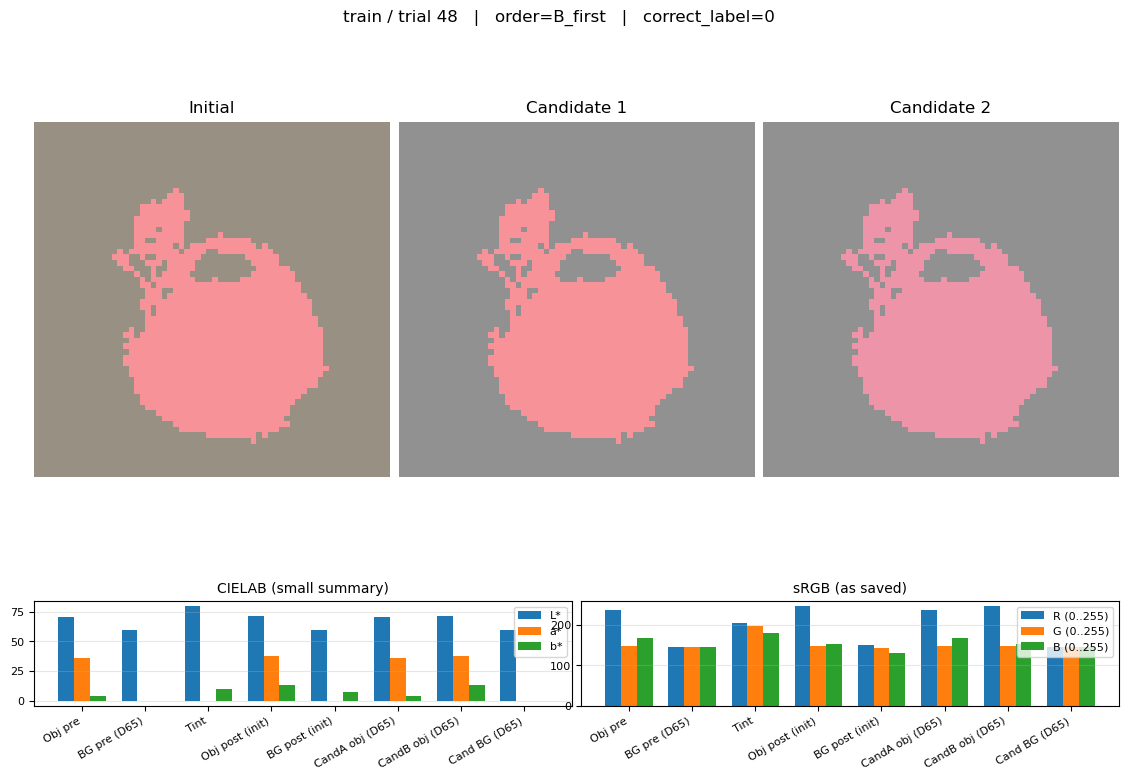

In [ ]:
# Cell 8 — GUI viewer: 3 large images side-by-side, 2 small bar charts side-by-side
from IPython.display import clear_output

def parse_vec_json(s):
    try:
        return np.array(json.loads(s), float)
    except Exception:
        return np.array([np.nan, np.nan, np.nan], float)

def vec_u8_to_np(s):
    try:
        return np.array(json.loads(s), int)
    except Exception:
        return np.array([np.nan, np.nan, np.nan], int)

def show_trial(split="train", tid=1):
    # Load row from manifest
    man_csv = OUT_ROOT / MANIFEST_SUBDIR / "trials.csv"
    df = pd.read_csv(man_csv)
    row = df[(df["split"]==split) & (df["trial_id"]==tid)]
    assert not row.empty, f"No manifest row for {split}/trial {tid}"
    r = row.iloc[0]

    tdir = OUT_ROOT / split / f"trial_{tid:06d}"
    # Load images as arrays (keeps them crisp at 64×64)
    init_img  = np.asarray(Image.open(tdir/"initial.png"))
    cand1_img = np.asarray(Image.open(tdir/"cand1.png"))
    cand2_img = np.asarray(Image.open(tdir/"cand2.png"))

    # ---- Use a single, consistent set of names for both Lab and sRGB ----
    names = [
        "Obj pre",
        "BG pre (D65)",
        "Tint",
        "Obj post (init)",
        "BG post (init)",
        "CandA obj (D65)",
        "CandB obj (D65)",
        "Cand BG (D65)",
    ]

    # Lab triplets
    labs = {
        "Obj pre":            parse_vec_json(r["obj_lab_pre"]),
        "BG pre (D65)":       parse_vec_json(r["bg_lab_pre"]),
        "Tint":               parse_vec_json(r["tint_lab"]),
        "Obj post (init)":    parse_vec_json(r["obj_lab_post_init"]),
        "BG post (init)":     parse_vec_json(r["bg_lab_post_init"]),
        "CandA obj (D65)":    parse_vec_json(r["candA_obj_lab"]),
        "CandB obj (D65)":    parse_vec_json(r["candB_obj_lab"]),
        "Cand BG (D65)":      parse_vec_json(r["bg_lab_pre"]),    # same as BG pre by design
    }

    # sRGB (as saved) — 0..255
    rgbs = {
        "Obj pre":            vec_u8_to_np(r["obj_rgb_pre"]),
        "BG pre (D65)":       vec_u8_to_np(r["bg_rgb_pre"]),
        "Tint":               vec_u8_to_np(r["tint_rgb"]),
        "Obj post (init)":    vec_u8_to_np(r["obj_rgb_post_init"]),
        "BG post (init)":     vec_u8_to_np(r["bg_rgb_post_init"]),
        "CandA obj (D65)":    vec_u8_to_np(r["candA_obj_rgb"]),
        "CandB obj (D65)":    vec_u8_to_np(r["candB_obj_rgb"]),
        "Cand BG (D65)":      vec_u8_to_np(r["cand_bg_rgb"]),
    }

    # Optional sanity check: candidate BG should equal BG pre (byte-identical)
    cand_bg_matches = np.array_equal(rgbs["Cand BG (D65)"], rgbs["BG pre (D65)"])

    # ---- Build figure: 2 rows, 6 columns (top images big, bottom charts small) ----
    fig = plt.figure(figsize=(14, 8))  # overall size
    gs = fig.add_gridspec(nrows=2, ncols=6, height_ratios=[4, 1], wspace=0.05, hspace=0.35)

    # Top row: three large image axes (each spans 2 columns)
    ax_i  = fig.add_subplot(gs[0, 0:2])
    ax_c1 = fig.add_subplot(gs[0, 2:4])
    ax_c2 = fig.add_subplot(gs[0, 4:6])

    ax_i.imshow(init_img, interpolation='nearest');  ax_i.set_title("Initial", fontsize=12)
    ax_c1.imshow(cand1_img, interpolation='nearest'); ax_c1.set_title("Candidate 1", fontsize=12)
    ax_c2.imshow(cand2_img, interpolation='nearest'); ax_c2.set_title("Candidate 2", fontsize=12)
    for ax in (ax_i, ax_c1, ax_c2):
        ax.axis('off')

    # Bottom row: two small bar charts, side-by-side
    ax_lab = fig.add_subplot(gs[1, 0:3])   # left half for Lab
    ax_rgb = fig.add_subplot(gs[1, 3:6])   # right half for sRGB

    # ---- Lab bar plot (small) ----
    Ls  = [labs[k][0] for k in names]
    a_s = [labs[k][1] for k in names]
    b_s = [labs[k][2] for k in names]
    x = np.arange(len(names))
    w = 0.25

    ax_lab.bar(x - w, Ls,  width=w, label='L*')
    ax_lab.bar(x,     a_s, width=w, label='a*')
    ax_lab.bar(x + w, b_s, width=w, label='b*')
    ax_lab.set_xticks(x, names, rotation=30, ha='right')
    ax_lab.set_title("CIELAB (small summary)", fontsize=10)
    ax_lab.grid(True, axis='y', alpha=0.3)
    ax_lab.legend(fontsize=8)
    ax_lab.tick_params(axis='both', labelsize=8)

    # ---- sRGB bar plot (small) ----
    Rs = [rgbs[k][0] for k in names]
    Gs = [rgbs[k][1] for k in names]
    Bs = [rgbs[k][2] for k in names]

    ax_rgb.bar(x - w, Rs, width=w, label='R (0..255)')
    ax_rgb.bar(x,     Gs, width=w, label='G (0..255)')
    ax_rgb.bar(x + w, Bs, width=w, label='B (0..255)')
    ax_rgb.set_xticks(x, names, rotation=30, ha='right')
    title = "sRGB (as saved)"
    if not cand_bg_matches:
        title += "  —  ⚠ BG mismatch!"
    ax_rgb.set_title(title, fontsize=10)
    ax_rgb.grid(True, axis='y', alpha=0.3)
    ax_rgb.legend(fontsize=8)
    ax_rgb.tick_params(axis='both', labelsize=8)

    # Overall title line with split/trial info
    fig.suptitle(f"{split} / trial {tid}   |   order={r['order']}   |   correct_label={r['correct_label']}",
                 fontsize=12, y=0.98)
    plt.show()

def browse_trials(split="train", start=1):
    tid = int(start)
    n = int(TRIALS[split])
    while True:
        clear_output(wait=True)
        show_trial(split, tid)
        cmd = input("Enter=next | p=prev | r=random | train|val|test | q=quit: ").strip().lower()
        if cmd in ("q", "quit", "x"):
            break
        elif cmd in ("p", "prev"):
            tid = max(1, tid - 1)
        elif cmd in ("r", "rand", "random"):
            tid = random.randint(1, n)
        elif cmd in ("train", "val", "test"):
            split = cmd
            n = int(TRIALS[split])
            tid = 1
        else:
            tid = min(n, tid + 1)

browse_trials("train", 1)

In [10]:
CSV = "/Users/kate/Documents/retina-model/image-set/manifests/trials.csv"
df = pd.read_csv(CSV)
print("First-try success rate:", (df["resample_attempts_total"]==1).mean())
print("By split:")
print(df.groupby("split")["resample_attempts_total"].agg(["mean","std","median","max","count"]))

# They should have the same sRGB bytes across the dataset (D65, no scaling).
# We stored per-trial swatch RGBs in the manifest—both candidates’ BG is 'cand_bg_rgb'.
bg_vals = df["cand_bg_rgb"].unique()
print("Unique candidate BG codes (should be 1):", len(bg_vals), bg_vals[:3])

def parse_lab(s): return np.array(json.loads(s), float)
df["tint_lab_vec"] = df["tint_lab"].apply(parse_lab)
df["tint_axis"] = df["tint_lab_vec"].apply(lambda v: "a*" if abs(v[1])>0 else "b*")
df["tint_radius"] = df["tint_lab_vec"].apply(lambda v: round(abs(v[1] if abs(v[1])>0 else v[2])))
print(df.groupby(["tint_axis","tint_radius"])["resample_attempts_total"].agg(["mean","count"]))

First-try success rate: 0.725
By split:
           mean       std  median  max  count
split                                        
test   1.625000  1.024695     1.0    4     16
train  1.335938  0.630927     1.0    4    128
val    1.312500  0.602080     1.0    3     16
Unique candidate BG codes (should be 1): 1 ['[145, 145, 145]']
                           mean  count
tint_axis tint_radius                 
a*        5            1.333333     18
          10           1.608696     23
          15           1.210526     19
          20           1.476190     21
b*        5            1.166667     18
          10           1.375000     16
          15           1.071429     14
          20           1.451613     31
